# 1d Open Channel, Gradually Varied, Flow Model
### CIVE 612
### Final Project
### Authors: Arif, Jacob, Phoebe

# Assumptions


# Capabilities
Rewrite problem statement

# Instructions for use
See README
Rewrite what is said in README

Resources used for model development are cited inline

## Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import integrate
from scipy.optimize import fmin
import pandas as pd
from math import hypot
from scipy.optimize import curve_fit
import matplotlib.image as mpimg
from sympy import symbols, Eq, solve 

In [ ]:
# optimization "Select Parameters with SSE Optimization": https://www.youtube.com/watch?v=qYdrLyY2bNk

In [ ]:
# using depth tolerance might be better because we can understand depth error (rather than mech eng head)

# Enter channel longitudinal characteristics

In [2]:
# enter length of channel and spatial step
dx = 1
l = 500
elev = 10 # datum at downstream
g = 9.81

In [3]:
# define function to find closest downstream value of x to structure
def find_nearest(x,value):
    idx = (np.abs(x-value)).argmin()
    if x[idx]<value:
        return x[idx]
    else:
        return x[idx-1]

# Enter upstream boundary condition parameters

In [ ]:
# enter upstream water level delivering flow to the canal through radial sluice gate
h1 = 5

# find parameters just d/s of gate



# Enter downstream boundary condition paramters

In [ ]:
# enter downstream sharp crested weir properties
# equations used:


# Enter bed slope information

In [4]:
# enter bed slope
s0 = 0.001
s1 = 0.0002
s2 = 0.0003

# enter locations of channel geometry change
# station 0 is at d/s end

xs0 = 100
xs1 = 350
xs2 = 450

x = np.arange(0,l,dx)

bedelev = []

for i in x:
    if i == 0:
        bedelev.append(elev)
    elif i <= xs0:
        bedelev.append(bedelev[i-1]+(dx*s0))
    elif i <= xs1:
        bedelev.append(bedelev[i-1]+(dx*s1))
    else:
        bedelev.append(bedelev[i-1]+(dx*s2))


# Enter cross sectional geometry information

In [ ]:
# enter cross sectional geometry
# start with prismatic channel
##w = 20
##h = 7

# enter locations of channel geometry change
##xgeo1 = 

# for regular cross section:
# gamma as a function of x, define piecewise function through loop

# for irregular cross section:
# enter power function parameters, or use calculator

# Enter hydraulic resistance

In [90]:
# enter hydraulic resistance
# example with change in resistance
n0 = 0.03
n1 = 0.01

# enter locations of n change
xn1 = 50
xn2 = 350

n = []

for i in station:
    if i <=xn1:
        n.append(n0)
    elif i <=xn2:
        n.append(n1)
    else:
        n.append(n0)


# Enter lateral inflow/outflow

In [92]:
# enter lateral inflow/outflow
# start with constant q
q0 = -0.5
q1 = 0
q2 = -0.001

# enter locations of q change
xq1 = 100
xq2 = 450

q = []

for i in station:
    if i <=xq1:
        q.append(q0)
    elif i <=xq2:
        q.append(q1)
    else:
        q.append(q2)

# enter kinetic energy correction factor

In [95]:
# enter kinetic energy correction factor
# start with alpha = 1
alpha0 = 1
alpha1 = 0.9

# enter location of alpha change
xalpha1 = 350

alpha = []

for i in station:
    if i <=xalpha1:
        alpha.append(alpha0)
    else:
        alpha.append(alpha1)
        

# enter contraction loss coefficients

In [157]:
# enter contraction loss coefficients
cc1 = 0.5
cc2 = 0.4

# enter expansion loss coefficients
ce1 = 0.4
ce2 = 0.8

# enter location of contraction
xc1 = np.arange(50,70,dx)
xc2 = np.arange(300,350,dx)

# enter location of expansions
xe1 = np.arange(70,80,dx)
xe2 = np.arange(350,400,dx)

u = np.random.uniform(low=2,high=10,size=(l)) # test values
ustar = np.random.uniform(low=2,high=10,size=(l)) # test values

# define function for change in energy head caused by contraction/expansion
def sudden(c,ustar,u,g):
    return c*np.absolute(((ustar**2)/(2*g))-((u**2)/(2*g)))

# solve for spatially varying headloss caused by contractions and expansions

Hec = []

for i in station:
    if (i !=xc1).all() and (i !=xc2).all() and (i !=xe1).all() and (i !=xe2).all():
        Hec.append(0)
    elif (i==xc1).any():
        Hec.append(sudden(cc1,ustar[i],u[i],g))
    elif (i==xc2).any():
        Hec.append(sudden(cc2,ustar[i],u[i],g))
    elif (i==xe1).any():
        Hec.append(sudden(ce1,ustar[i],u[i],g))
    else:
        Hec.append(sudden(ce2,ustar[i],u[i],g))


In [151]:
# enter bend loss coefficients
cb1 = 0.055
cb2 = 0.058

# enter location of channel bends
xb1 = np.arange(50,70,dx)
xb2 = np.arange(400,420,dx)

u = np.random.uniform(low=2,high=10,size=(l)) # test values

# define function for change in energy head caused by bend
def bend(c,u,g):
    return c*(u**2)/(2*g)

# solve for spatially varying headloss caused by bend
Hb = []

for i in station:
    if (i !=xb1).all() and (i !=xb2).all():
        Hb.append(0)
    elif (i==xb1).any():
        Hb.append(bend(cb1,u[i],g))
    else:
        Hb.append(bend(cb2,u[i],g))
        

# Calculate flow conditions for mid reach broad crested weir

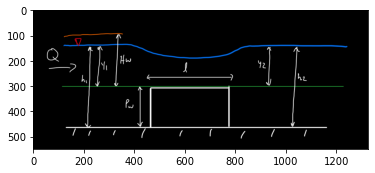

In [3]:
img = mpimg.imread('broadweir.jpg')
imgplot = plt.imshow(img)
plt.show()

In [15]:
# in-stream regulating structure located mid length (broad crested weir or vertical sluice gate)

# if running model from downstream, h2 is known, h1 is unknown
# possible Q calculated from Hw
# Q is known, Hw unknown. Calc Hw from known Q, guess h1 based on h2 and Hw

# define location of structure
xin = l/2

# if cross section falls on structure, delete it
#df.drop([xin])

# find the closest downstream value of x
closest_idx = find_nearest(x,xin) 

# define required parameters
#h2 = df.iat[closest_idx,'depth'] # d/s calculated depth, assuming x values are index in pandas df
h2 = 2.8
#Q = df.iat[closets_idx,'flow'] # flow at structure
Q = 23.6
L = 10 # cross sectional length
#A = df.iat[closets_idx,'area'] # area at structure
A = 20
inL = 3 # in-stream length
g = 32.2 # rewrite with consistent units for final model
pw = 2 # height of weir
y2 = h2-pw

In [17]:
# https://clouds.eos.ubc.ca/~phil/docs/problem_solving/10-Symbolic-Math/10.07-Solving-Two-Equations-for-Two-Unknowns.html
Cd, Hw = symbols('Cd Hw')

eq1 = Eq(0.93+0.1*(Hw/inL)-Cd)
eq2 = Eq(((Q/((2/3)*((2*g/3)**(1/2))*Cd*L))**(2/3))-Hw)

sol = solve((eq1,eq2), (Cd, Hw),dict=True)

Cd = sol[0][Cd]
Hw = sol[0][Hw]

# check if broad crested weir equations are appropriate
print('broad' if Hw/inL >=0.07 and Hw/inL<=0.7 else 'cannot compute')

H = Hw-(((Q/A)**2)/(2*g))
h1 = H + pw
y1 = h1-pw

S= y2/y1 #submergence >= 0.65, flow submerged
print('submerged' if S>=0.65 else 'free')

# solve for submerged flow
# NOT SURE IF THIS IS WORKING CORRECTLY, NEED TO TEST
if S>=0.65:
    fs = (9.815-(7.55*S**2)-2.26)**(1/3)
    Q2 = Q*fs
    eq2a = Eq((((Q2/((2/3)*((2*g/3)**(1/2))*Cd*L))**(2/3))-Hw))
    sol2 = solve((eq1,eq2a), (Cd, Hw),dict=True)
    Cd = sol2[0][Cd]
    Hw = sol2[0][Hw]
    H = Hw-(((Q/A)**2)/(2*g))
    h1 = H + pw
    y1 = h1-pw

# This h1 will be used in next upstream cross section as h2
print(h1)
print(Hw)
print(Cd)

broad
submerged


C:\Users\GSCOB\AppData\Local\Temp\ipykernel_17504\2531349058.py:4: SymPyDeprecationWarning: 

Eq(expr) with a single argument with the right-hand side
defaulting to 0 is deprecated. Use Eq(expr, 0) instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-eq-expr
for details.

This has been deprecated since SymPy version 1.5. It
will be removed in a future version of SymPy.

  eq1 = Eq(0.93+0.1*(Hw/inL)-Cd)


IndexError: list index out of range

# Calculate flow conditions for offtake structures

In [ ]:
# radial sluice off-take structures

# define locations of gates upstream of regulating structure
xgate1 = 
xgate2 = 
xgate3 = 

# define locations of gates downstream of regulating structure
xgate4 = 
xgate5 = 

In [ ]:
# calculate flow rate
# equations used:

# create plot that shows flow rate as a function of position, if result merges on accurate solution




In [ ]:
# calculate cross sectional averaged velocity
# equations used:


# plot over x

In [ ]:
# calculate flow depth

# equations used:


# plot over x

In [ ]:
# calculate water surface elevation
# equations used:

# plot over x


In [ ]:
# calculate Froude number
# equations used:


# plot over x


In [ ]:
# calculate total mechanical energy head
# equations used:


# plot over x


In [ ]:
# calculate off-take flow rates
# equations used:


# plot over x
